In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from numpy import array
from datetime import datetime
import seaborn as sns

2022-10-19 00:23:54.732420: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-19 00:23:54.732453: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sns.set_style("darkgrid")
cm = 1/2.54 
colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

### Replace missing values with Zero and Group by month

In [3]:
df= pd.read_csv('consumos.csv', parse_dates=['date'])
df['nr'].fillna(value=0, inplace=True)
df=df.groupby('date').sum()
df=df.resample(rule='W').sum()
df = df.iloc[:-1 , :]

### Create batches of training data (12 months)

In [4]:
def split_sequence(sequence, n_steps_in, n_steps_out, slide):
    X, y = list(), list()
    for i in range(0, len(sequence), slide):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Define and fit LSTM model 

In [5]:
def fit(X, y, n_steps_in, n_steps_out):
    callback = EarlyStopping(monitor='loss', patience=50)
    model = Sequential()
    model.add(Dense(500, activation='relu', input_shape=(n_steps_in,)))
    model.add(Dense(500, activation='relu', 
                kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-3),
                bias_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=500, verbose=1, callbacks=[callback])
    return model 

In [6]:
def train_predict(dataset, test, actual):
    n_steps_in, n_steps_out, slide = 24, 8, 1
    X, y = split_sequence(train['nr'].values.tolist(), n_steps_in, n_steps_out, slide)
    
    model = fit(X, y, n_steps_in, n_steps_out)
        
    mae, rmse, smape = list(), list(), list()
    for i in range(0, len(test)-n_steps_in, n_steps_out):
        x_input = array(test[i:n_steps_in+i])
        x_input = x_input.reshape((1, n_steps_in)) 
        pred = model.predict(x_input) 
        mae_aux, rmse_aux, smape_aux = measure_error(test, pred, n_steps_in, n_steps_out, i)
        mae.append(mae_aux), rmse.append(rmse_aux), smape.append(smape_aux)
    
    return mae, rmse, smape

In [7]:
def sMAPE(actual, predicted):
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)
    return round(np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual))/2))*100, 2)

In [8]:
def measure_error(actual, pred, step_in, step_out, index):
    #print(actual[index+step_in:index+step_in+step_out],pred,index+step_in,index+step_in+step_out)
    mae = mean_absolute_error(array([actual['nr'][index+step_in:index+step_in+step_out]]), pred)
    rmse = np.sqrt(mean_squared_error(array([actual['nr'][index+step_in:index+step_in+step_out]]), pred))
    smape = sMAPE(array([actual['nr'][index+step_in:index+step_in+step_out]]), pred)
    return mae, rmse, smape

### Normalize Data Set and Split Train and Test

In [9]:
len(df)

1096

In [10]:
train=df[:952]
test=df[952:]
mae, rmse, smape = train_predict(train, test, test.values)

2022-10-19 00:23:58.338598: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-19 00:23:58.338726: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-10-19 00:23:58.340555: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/500
29/29 [==============================] - 1s 10ms/step - loss: 2084878.5000
Epoch 2/500
29/29 [==============================] - 0s 9ms/step - loss: 242061.3438
Epoch 3/500
29/29 [==============================] - 0s 9ms/step - loss: 230431.2031
Epoch 4/500
29/29 [==============================] - 0s 10ms/step - loss: 225926.5625
Epoch 5/500
29/29 [==============================] - 0s 9ms/step - loss: 224717.0938
Epoch 6/500
29/29 [==============================] - 0s 9ms/step - loss: 230648.3594
Epoch 7/500
29/29 [==============================] - 0s 9ms/step - loss: 223445.8125
Epoch 8/500
29/29 [==============================] - 0s 10ms/step - loss: 219108.8594
Epoch 9/500
29/29 [==============================] - 0s 8ms/step - loss: 219526.2656
Epoch 10/500
29/29 [==============================] - 0s 11ms/step - loss: 213350.0938
Epoch 11/500
29/29 [==============================] - 0s 9ms/step - loss: 215763.0625
Epoch 12/500
29/29 [==============================] - 0s 9

29/29 [==============================] - 0s 7ms/step - loss: 199547.6250
Epoch 97/500
29/29 [==============================] - 0s 6ms/step - loss: 196232.2188
Epoch 98/500
29/29 [==============================] - 0s 7ms/step - loss: 194800.1250
Epoch 99/500
29/29 [==============================] - 0s 7ms/step - loss: 198105.7188
Epoch 100/500
29/29 [==============================] - 0s 7ms/step - loss: 195125.0000
Epoch 101/500
29/29 [==============================] - 0s 7ms/step - loss: 209151.6875
Epoch 102/500
29/29 [==============================] - 0s 7ms/step - loss: 195450.0000
Epoch 103/500
29/29 [==============================] - 0s 7ms/step - loss: 195475.5625
Epoch 104/500
29/29 [==============================] - 0s 7ms/step - loss: 196297.4375
Epoch 105/500
29/29 [==============================] - 0s 7ms/step - loss: 196326.6406
Epoch 106/500
29/29 [==============================] - 0s 7ms/step - loss: 199269.7500
Epoch 107/500
29/29 [==============================] - 0s 7m

29/29 [==============================] - 0s 12ms/step - loss: 188460.8750
Epoch 191/500
29/29 [==============================] - 0s 10ms/step - loss: 188424.6562
Epoch 192/500
29/29 [==============================] - 0s 10ms/step - loss: 186155.4375
Epoch 193/500
29/29 [==============================] - 0s 12ms/step - loss: 184586.7500
Epoch 194/500
29/29 [==============================] - 0s 11ms/step - loss: 190313.1562
Epoch 195/500
29/29 [==============================] - 0s 11ms/step - loss: 184699.9375
Epoch 196/500
29/29 [==============================] - 0s 12ms/step - loss: 183909.9531
Epoch 197/500
29/29 [==============================] - 0s 13ms/step - loss: 182114.7500
Epoch 198/500
29/29 [==============================] - 0s 11ms/step - loss: 185790.1094
Epoch 199/500
29/29 [==============================] - 0s 12ms/step - loss: 181778.1562
Epoch 200/500
29/29 [==============================] - 0s 11ms/step - loss: 186590.5000
Epoch 201/500
29/29 [=========================

29/29 [==============================] - 0s 8ms/step - loss: 171343.1875
Epoch 284/500
29/29 [==============================] - 0s 7ms/step - loss: 167807.8438
Epoch 285/500
29/29 [==============================] - 0s 10ms/step - loss: 174368.4375
Epoch 286/500
29/29 [==============================] - 0s 9ms/step - loss: 169349.5938
Epoch 287/500
29/29 [==============================] - 0s 8ms/step - loss: 173435.8281
Epoch 288/500
29/29 [==============================] - 0s 8ms/step - loss: 173629.4219
Epoch 289/500
29/29 [==============================] - 0s 10ms/step - loss: 168664.5312
Epoch 290/500
29/29 [==============================] - 0s 10ms/step - loss: 165718.7969
Epoch 291/500
29/29 [==============================] - 0s 11ms/step - loss: 168388.7656
Epoch 292/500
29/29 [==============================] - 0s 11ms/step - loss: 172544.0469
Epoch 293/500
29/29 [==============================] - 0s 9ms/step - loss: 169165.7031
Epoch 294/500
29/29 [==============================]

29/29 [==============================] - 0s 7ms/step - loss: 133482.9688
Epoch 377/500
29/29 [==============================] - 0s 7ms/step - loss: 140938.9688
Epoch 378/500
29/29 [==============================] - 0s 7ms/step - loss: 140928.9688
Epoch 379/500
29/29 [==============================] - 0s 8ms/step - loss: 132870.2812
Epoch 380/500
29/29 [==============================] - 0s 7ms/step - loss: 133755.3594
Epoch 381/500
29/29 [==============================] - 0s 8ms/step - loss: 136634.4688
Epoch 382/500
29/29 [==============================] - 0s 10ms/step - loss: 130209.4688
Epoch 383/500
29/29 [==============================] - 0s 11ms/step - loss: 132462.2031
Epoch 384/500
29/29 [==============================] - 0s 12ms/step - loss: 128992.0078
Epoch 385/500
29/29 [==============================] - 0s 8ms/step - loss: 134292.3750
Epoch 386/500
29/29 [==============================] - 0s 10ms/step - loss: 131817.0312
Epoch 387/500
29/29 [==============================] 

29/29 [==============================] - 0s 8ms/step - loss: 98797.1953
Epoch 470/500
29/29 [==============================] - 0s 7ms/step - loss: 102664.6406
Epoch 471/500
29/29 [==============================] - 0s 6ms/step - loss: 97050.3281
Epoch 472/500
29/29 [==============================] - 0s 7ms/step - loss: 98164.8672
Epoch 473/500
29/29 [==============================] - 0s 7ms/step - loss: 101174.3906
Epoch 474/500
29/29 [==============================] - 0s 8ms/step - loss: 101824.4141
Epoch 475/500
29/29 [==============================] - 0s 8ms/step - loss: 100335.6016
Epoch 476/500
29/29 [==============================] - 0s 12ms/step - loss: 99371.0312
Epoch 477/500
29/29 [==============================] - 0s 11ms/step - loss: 98300.0078
Epoch 478/500
29/29 [==============================] - 0s 8ms/step - loss: 97529.3828
Epoch 479/500
29/29 [==============================] - 0s 8ms/step - loss: 95302.3906
Epoch 480/500
29/29 [==============================] - 0s 8ms/

In [11]:
len(smape)

15

### Calculate Error

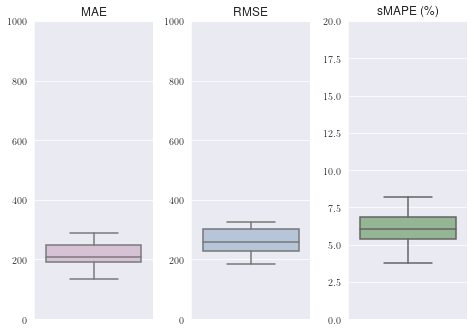

In [12]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(17*cm,12*cm))
sns.boxplot(ax=axes[0], y=mae, color='thistle', showfliers=False)
axes[0].set_title('MAE')
axes[0].set(ylim=(0, 1000))
sns.boxplot(ax=axes[1], y=rmse, color='lightsteelblue', showfliers=False)
axes[1].set_title('RMSE')
axes[1].set(ylim=(0, 1000))
sns.boxplot(ax=axes[2], y=smape, color='darkseagreen', showfliers=False)
axes[2].set_title('sMAPE (\%)')
axes[2].set(ylim=(0, 20))
plt.tight_layout()
#plt.savefig('figures/demand_mlp_weekly_boxplot.pdf')

In [14]:
demand_mlp_week = [mae,rmse,smape]
%store demand_mlp_week

Stored 'demand_mlp_week' (list)
